In [1]:
import pybamm
import battery_param_pipeline as bpp
import os
import matplotlib.pyplot as plt
import numpy as np


def schimpe2018():
    def negative_ocp(sto):
        u_eq = (
            0.6379
            + 0.5416 * pybamm.exp(-305.5309 * sto)
            + 0.044 * pybamm.tanh(-(sto - 0.1958) / 0.1088)
            - 0.1978 * pybamm.tanh((sto - 1.0571) / 0.0854)
            - 0.6875 * pybamm.tanh((sto + 0.0117) / 0.0529)
            - 0.0175 * pybamm.tanh((sto - 0.5692) / 0.0875)
        )

        return u_eq

    def positive_ocp(sto):
        u_eq = (
            3.4323
            - 0.8428 * pybamm.exp(-80.2493 * (1 - sto) ** 1.3198)
            - 3.2474e-6 * pybamm.exp(20.2645 * (1 - sto) ** 3.8003)
            + 3.2482e-6 * pybamm.exp(20.2646 * (1 - sto) ** 3.7995)
        )

        return u_eq

    parameters = {
        # negative electrode
        "Maximum concentration in negative electrode [mol.m-3]": 3.14e4,
        "Negative electrode thickness [m]": 6.01e-5,
        "Negative electrode active material volume fraction": 0.486,
        "Negative electrode OCP [V]": negative_ocp,
        "Negative electrode OCP entropic change [V.K-1]": 0,
        "Maximum stoichiometry in negative electrode": 0.78,
        "Minimum stoichiometry in negative electrode": 0.0085,
        # Positive electrode
        "Maximum concentration in positive electrode [mol.m-3]": 2.28e4,
        "Positive electrode thickness [m]": 7.9e-5,
        "Positive electrode active material volume fraction": 0.455,
        "Positive electrode OCP [V]": positive_ocp,
        "Positive electrode OCP entropic change [V.K-1]": 0,
        "Minimum stoichiometry in positive electrode": 0.045,
        "Maximum stoichiometry in positive electrode": 0.916,
        # cell
        "Electrode area [m2]": 1.57e-1,
    }
    source = "Parameters for a graphite-LFP system from Schimpe et al. (2018)"

    return bpp.direct_entries.DirectEntry(parameters, source)


class CapacityCalculation(bpp.calculations.Calculation):
    """
    Calculate the capacity of the electrodes from the loading
    """

    def __init__(self):
        source = "Calculation of electrode capacity from loading"
        super().__init__(source)

    def run(self, parameter_values):
        F = pybamm.constants.F.value
        A_cc = parameter_values["Electrode area [m2]"]

        capacity_parameter_values = {}
        for side in ["negative", "positive"]:
            Side = side.capitalize()
            L = parameter_values[f"{Side} electrode thickness [m]"]
            c_max = parameter_values[
                f"Maximum concentration in {side} electrode [mol.m-3]"
            ]
            eps = parameter_values[f"{Side} electrode active material volume fraction"]

            Q_loading = L * eps * c_max * F / 3600  # A.h.m-2
            Q = Q_loading * A_cc  # Ah

            capacity_parameter_values.update(
                {
                    f"{Side} electrode loading [A.h.cm-2]": Q_loading / 1e4,
                    f"{Side} electrode capacity [A.h]": Q,
                }
            )

            sto_min = parameter_values[f"Minimum stoichiometry in {side} electrode"]
            sto_max = parameter_values[f"Maximum stoichiometry in {side} electrode"]
            Q_cell = Q * (sto_max - sto_min)
            capacity_parameter_values.update(
                {f"Cell capacity from {side} electrode [A.h]": Q_cell}
            )

        # Evaluate voltage
        x_100 = parameter_values["Maximum stoichiometry in negative electrode"]
        x_0 = parameter_values["Minimum stoichiometry in negative electrode"]
        y_100 = parameter_values["Minimum stoichiometry in positive electrode"]
        y_0 = parameter_values["Maximum stoichiometry in positive electrode"]
        U_n = parameter_values["Negative electrode OCP [V]"]
        U_p = parameter_values["Positive electrode OCP [V]"]

        V_max = U_p(y_100) - U_n(x_100)
        V_min = U_p(y_0) - U_n(x_0)

        capacity_parameter_values.update(
            {"Upper voltage cut-off [V]": V_max, "Lower voltage cut-off [V]": V_min}
        )
        return capacity_parameter_values


pipeline = bpp.Pipeline(
    [
        ("defaults", bpp.direct_entries.standard_defaults()),
        ("temperatures", bpp.direct_entries.temperatures(298.15)),
        ("Schimpe2018", schimpe2018()),
        ("dimensions", bpp.calculations.AreaToSquareWidthHeight()),
        ("capacity", CapacityCalculation()),
    ],
)
parameter_values = pipeline.run()

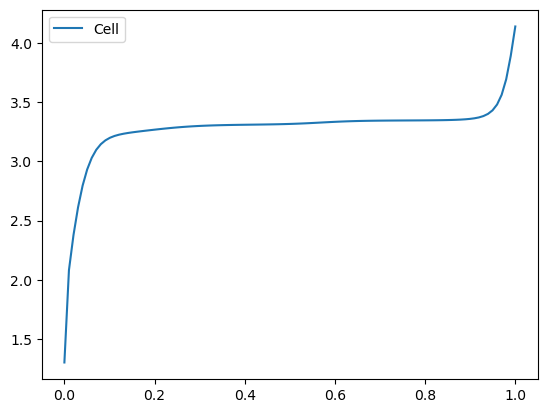

In [5]:
fig, ax = plt.subplots()
x_100 = parameter_values["Maximum stoichiometry in negative electrode"]
x_0 = parameter_values["Minimum stoichiometry in negative electrode"]
y_100 = parameter_values["Minimum stoichiometry in positive electrode"]
y_0 = parameter_values["Maximum stoichiometry in positive electrode"]

def U_n(x):
    x = pybamm.Vector(x)
    return parameter_values["Negative electrode OCP [V]"](x).evaluate()

def U_p(y):
    y = pybamm.Vector(y)
    return parameter_values["Positive electrode OCP [V]"](y).evaluate()

x_0 = 0
x_100 = 1
y_100 = 0
y_0 = 1
x = np.linspace(x_0, x_100, 100)
y = np.linspace(y_0, y_100, 100)
soc = np.linspace(0, 1, 100)

# ax.plot(soc, U_n(soc), label="Negative electrode")
# ax.plot(soc, U_p(soc), label="Positive electrode")
ax.plot(soc, U_p(y) - U_n(x), label="Cell")
ax.legend()